<a href="https://colab.research.google.com/github/dh610/ai-intensive2/blob/main/lab7/RNN-character.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ai-intensive2
!git pull
%cd lab7

Mounted at /content/drive
/content/drive/MyDrive/ai-intensive2
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 12 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (12/12), 109.35 KiB | 48.00 KiB/s, done.
From https://github.com/dh610/ai-intensive2
   23e54ac..1ac028b  main       -> origin/main
Updating 23e54ac..1ac028b
Fast-forward
 lab7/LSTM-pos-tagging.ipynb | 27093 +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++-
 lab7/RNN-character.ipynb    |   936 ++-
 lab7/quiz.ipynb             |   642 +-
 3 files changed, 28351 insertions(+), 320 deletions(-)
/content/drive/MyDrive/ai-intensive2/lab7


# RNN tutorial: 성(姓)을 보고 18개 언어를 예측하는 모델 만들기
```
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

## 데이터 다운로드 및 압축 해제
data/names 디렉토리에는 [Language].txt 라는 18 개의 텍스트 파일이 있습니다. 각 파일에는 한 줄에 하나의 이름이 포함되어 있으며 대부분 로마자로 되어 있습니다. (그러나, 유니코드에서 ASCII로 변환해야 함).

각 언어 별로 이름 목록 사전 {language: [names ...]} 을 만듭니다. 일반 변수 "category" 와 "line" (우리의 경우 언어와 이름)은 이후의 확장성을 위해 사용됩니다.

In [3]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2024-11-27 04:39:47--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.143.48, 18.160.143.107, 18.160.143.21, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.143.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  10.1MB/s    in 0.3s    

2024-11-27 04:39:47 (10.1 MB/s) - ‘data.zip.1’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/eng-fra.txt        
replace data/names/Arabic.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/names/Arabic.txt   
replace data/names/Chinese.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/names/Chinese.txt  
replace data/names/Czech.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/names/Czech.txt    
replace data/n

In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print("글자 개수", n_letters)
print(unicodeToAscii('Ślusàrski'))

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']
글자 개수 57
Slusarski


In [5]:
# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### One-hot encoding
![](https://blog.kakaocdn.net/dn/dOX5bg/btqEeo9ocuK/kdlLkObkKmweNjXQiSFSBk/img.png)

One-Hot 벡터는 언어를 다룰 때 자주 이용되며,
단어, 글자 등을 벡터로 표현할 때 단어, 글자 사이의 상관 관계를 미리 알 수 없을 경우,
One-Hot으로 표현하여 서로 직교한다고 가정하고 학습을 시작합니다.
이와 동일하게, 상관 관계를 알 수 없는 다른 데이터의 경우에도 One-Hot 벡터를 활용할 수 있습니다.

In [6]:
import torch

# all_letters 로 문자의 주소 찾기, 예시 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해서 한 개의 문자를 <1 x n_letters> Tensor로 변환
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 One-Hot 문자 벡터의 Array로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## RNN Modeling
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/01/Untitled-Diagram.png)<br/>

https://www.youtube.com/shorts/r1QJbC4-vUA

![](https://i.imgur.com/Z2xbySO.png)


In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)

        # update the hidden state
        hidden = self.i2h(combined)

        # make a output from input and previous hidden
        output = self.i2o(combined)

        # calculate softmax for multi-class classification
        output = self.softmax(output)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
input = letterToTensor('A')
hidden = rnn.initHidden()

output, next_hidden = rnn(input, hidden)
print(output, output.shape)
print(next_hidden, next_hidden.shape)

tensor([[-2.8990, -2.8911, -2.9600, -2.8782, -2.9107, -2.8286, -2.9191, -2.8212,
         -2.8661, -2.8557, -2.8102, -2.8825, -3.0023, -2.8266, -2.9157, -2.9526,
         -2.9542, -2.8772]], grad_fn=<LogSoftmaxBackward0>) torch.Size([1, 18])
tensor([[ 0.0774,  0.0936,  0.1040, -0.0634,  0.1064, -0.0811, -0.0710, -0.0070,
          0.0175,  0.0413,  0.0287,  0.0242, -0.1244,  0.0541,  0.0317,  0.0193,
          0.0543, -0.0116,  0.0265,  0.0455, -0.1105,  0.0619, -0.0604,  0.0803,
         -0.0789, -0.1038,  0.0785, -0.0337, -0.0420, -0.0081, -0.0258,  0.0544,
         -0.0759,  0.1144,  0.0092, -0.0533,  0.0615, -0.0626, -0.0421,  0.0893,
          0.0057, -0.0197, -0.0869, -0.0267, -0.0942, -0.0487, -0.0014,  0.1011,
          0.0039,  0.1297,  0.0050,  0.0531,  0.0423,  0.0304, -0.0103, -0.1235,
         -0.1345, -0.0452,  0.0059, -0.0020, -0.0051,  0.0463,  0.0639, -0.0241,
          0.1340, -0.0534, -0.0445,  0.0493,  0.0226,  0.0410, -0.0057,  0.0245,
         -0.0135, -0.0655,  0

In [ ]:
input = lineToTensor('Albert')
hidden = rnn.initHidden()

print("input", input, input.shape)

output, hidden1 = rnn(input[0], hidden)
print("hidden1", hidden1)

output, hidden2 = rnn(input[1], hidden1)
print("hidden2", hidden2)

output, hidden3 = rnn(input[2], hidden2)
print("hidden3", hidden3)

print(output)

input tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.,

## Question
1. log-softmax를 쓰는 이유는 무엇일까요?

## Training

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)  # 텐서의 가장 큰 값 및 주소
    print(top_n, top_i)
    category_i = top_i[0].item()   # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

tensor([[-0.9727, -1.7895, -2.4803]], grad_fn=<TopkBackward0>) tensor([[ 5, 13,  4]])
('Dutch', 5)


In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Chinese / line = Long
category = Scottish / line = Stevenson
category = Italian / line = Quaranta
category = Polish / line = Slazak
category = Russian / line = Deryujinsky
category = Vietnamese / line = Phan
category = Japanese / line = Nonomura
category = Spanish / line = Albert
category = Scottish / line = Murray
category = English / line = Abrahams


In [ ]:
criterion = nn.NLLLoss()

In [ ]:
learning_rate = 0.005  # 학습률을 너무 높게 설정하면 발산할 수 있고, 너무 낮으면 학습이 되지 않을 수 있습니다.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    # 구현: 한 글자씩 RNN 모델에 넣으면서 마지막 output을 가져와봅시다
    for i in range(line_tensor.size()[0]):
      input = line_tensor[i]
      output, hidden = rnn(input, hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # ``iter`` 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.3201 Kalinchuk / Russian ✓
10000 10% (0m 14s) 1.3254 Cao / Chinese ✗ (Vietnamese)
15000 15% (0m 21s) 1.1084 Seok / Korean ✓
20000 20% (0m 28s) 2.4717 Sault / Arabic ✗ (French)
25000 25% (0m 34s) 2.2754 Allwood / Scottish ✗ (English)
30000 30% (0m 42s) 3.5338 Hay / Chinese ✗ (Scottish)
35000 35% (0m 49s) 1.3820 Zobkob / Greek ✗ (Russian)
40000 40% (0m 55s) 2.0672 Rosario / Spanish ✗ (Portuguese)
45000 45% (1m 3s) 0.2279 Nomikos / Greek ✓
50000 50% (1m 9s) 1.0701 Thian / Vietnamese ✗ (Chinese)
55000 55% (1m 16s) 1.4424 Pfeifer / German ✗ (Czech)
60000 60% (1m 23s) 0.9628 Anami / Japanese ✓


KeyboardInterrupt: ignored

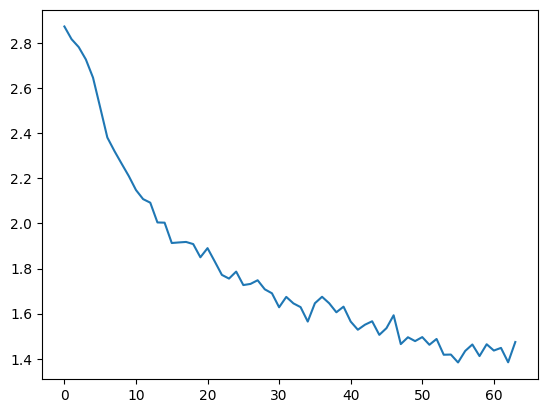

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## 모델 평가

<ipython-input-15-6bf7967722dc>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-15-6bf7967722dc>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


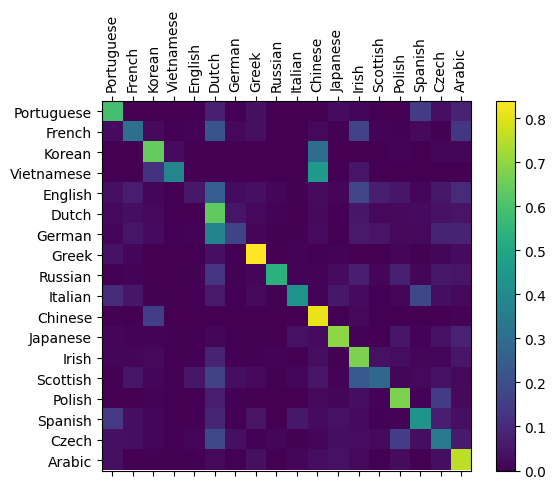

In [ ]:
# 혼란 행렬에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 예시 중 어떤 것이 정확히 예측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
@torch.no_grad()
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    # 구현: 가장 확률이 높은 언어를 n_predictions 만큼 가져오기
    output = evaluate(lineToTensor(input_line))
    print(output.shape)

    values, indices = output.topk(n_predictions)
    print(values, indices)

    for val, index in zip(values[0], indices[0]):
      print(val.item(), all_categories[index.item()])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
torch.Size([1, 18])
tensor([[-0.6952, -1.4393, -1.4914]]) tensor([[16,  8, 14]])
-0.695156455039978 Czech
-1.4393118619918823 Russian
-1.4914311170578003 Polish

> Jackson
torch.Size([1, 18])
tensor([[-0.9213, -1.7067, -2.0377]]) tensor([[13,  4,  8]])
-0.9213334321975708 Scottish
-1.7066501379013062 English
-2.037691593170166 Russian

> Satoshi
torch.Size([1, 18])
tensor([[-1.2843, -1.6921, -2.2320]]) tensor([[14, 11, 17]])
-1.2843358516693115 Polish
-1.6921491622924805 Japanese
-2.2320079803466797 Arabic


## 한계점

1. 한번에 이름 하나씩 학습했기 때문에 굉장히 느리다. 배치로 학습할 경우 이름마다 길이가 다르기 때문에 패딩을 추가해야한다.

![](https://velog.velcdn.com/images%2Fuonmf97%2Fpost%2Fa1a49bfd-a03b-4e95-a4e6-860f9cc12c20%2FScreen%20Shot%202021-08-23%20at%209.25.05%20PM.png)

2. Question: 이렇게 패딩 문자열을 넣으면 어떤 문제점이 있을까요?

참조
- https://colab.research.google.com/github/PyTorchKorea/tutorials-kr/blob/master/docs/_downloads/13b143c2380f4768d9432d808ad50799/char_rnn_classification_tutorial.ipynb
